In [1]:
# Package specific
import set_sys_path
from classy.model.data.read import Reader

# Data wranglers
import numpy as np
import pandas as pd

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Reporting and testing
from sklearn import metrics
from sklearn.model_selection import (
    cross_validate,
    cross_val_predict
)
import scikitplot as skplt
from tabulate import tabulate


### Loading the dataset

In [2]:
reader = Reader()
dataset = reader.load_data("dataframe_with_class_attribute")
dataset.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,label
12163,230,223,195,135,154,173,184,154,138,127,...,114,113,113,112,110,109,111,115,118,38
10376,51,49,119,157,153,145,88,53,50,46,...,93,97,100,95,83,72,67,65,59,38
3580,46,44,42,41,40,41,43,42,41,41,...,41,32,31,30,30,30,29,28,27,6
8185,177,172,160,179,183,190,188,189,186,189,...,148,152,145,147,154,159,163,164,166,13
1103,255,255,255,255,255,255,255,255,255,255,...,62,62,63,63,63,65,63,58,53,3
13,15,16,16,16,15,14,14,15,15,16,...,37,37,34,33,35,37,39,36,30,3
6858,92,93,102,111,108,104,99,87,71,57,...,47,49,44,40,33,28,24,22,21,12
9014,19,21,23,21,19,20,23,20,17,18,...,23,19,21,23,22,19,19,19,20,13
5952,67,66,66,65,65,65,65,65,65,65,...,26,23,21,20,21,22,22,22,23,12
10782,76,88,81,51,34,27,26,26,26,26,...,66,144,243,235,202,165,145,133,178,38


I'm using the original image labels. Below is a mappaging of their numeric and nominal labels

In [3]:
labels_mapping = {
    3: "speed_limit_60",
    5: "speed_limit_80",
    6: "speed_limit_80_lifted",
    11: "right_of_way_crossing",
    12: "right_of_way_general",
    13: "give_way",
    14: "stop",
    32: "no_speed_limit_general",
    38: "turn_right_down",
    39: "turn_left_down",
}

Seperate the labels and instances (y and X) into numpy arrays.

In [4]:
# Labels
labels = dataset['label'].values
# Instances and features
instances_and_features = dataset.iloc[:, :-1].values

print("Labels shape: ", labels.shape)
print("Instances and Features shape: ", instances_and_features.shape)

Labels shape:  (12660,)
Instances and Features shape:  (12660, 2304)


### Class Frequencies

In [5]:
table = []
for class_frequency in dataset['label'].value_counts().iteritems():
    # Print a table: Name, Class, Frequency
    table.append([labels_mapping[class_frequency[0]], class_frequency[0], class_frequency[1]])

print(tabulate(
    table,
    headers=["Name", "Class", "Frequency"]
))

Name                      Class    Frequency
----------------------  -------  -----------
give_way                     13         2160
right_of_way_general         12         2100
turn_right_down              38         2070
speed_limit_80                5         1860
speed_limit_60                3         1410
right_of_way_crossing        11         1320
stop                         14          780
speed_limit_80_lifted         6          420
turn_left_down               39          300
no_speed_limit_general       32          240


### Data Preparation

Both the linear classifier work best with the data set to between 0 and 1. For this we shall use scikit-learn's MinMaxScaller.

In [6]:
scaler = MinMaxScaler()
scaler.fit(instances_and_features)
instances_and_features = scaler.transform(instances_and_features)
pd.DataFrame(instances_and_features).describe()

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
count,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,...,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000,12660.000000
mean,0.341104,0.338542,0.341324,0.338833,0.339795,0.340773,0.341819,0.343082,0.346266,0.344479,...,0.265556,0.263243,0.262648,0.260965,0.260258,0.253991,0.250359,0.247859,0.247932,0.251136
std,0.318127,0.319977,0.319265,0.320869,0.321117,0.321615,0.322356,0.322917,0.321757,0.323121,...,0.263628,0.262319,0.262993,0.263653,0.260438,0.258349,0.254266,0.251759,0.252817,0.253157
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.096000,0.092369,0.096000,0.088353,0.088353,0.088353,0.088353,0.088353,0.092000,0.092369,...,0.080321,0.076305,0.076305,0.076305,0.080000,0.072289,0.072289,0.072289,0.072289,0.076000
50%,0.200000,0.200803,0.200000,0.196787,0.200803,0.200803,0.200803,0.200803,0.208000,0.204819,...,0.164659,0.164659,0.164659,0.160643,0.160000,0.152610,0.152610,0.152610,0.148594,0.152000
75%,0.524000,0.522088,0.520000,0.522088,0.526104,0.526104,0.538153,0.538153,0.540000,0.538153,...,0.353414,0.349398,0.349398,0.345382,0.344000,0.337349,0.329317,0.325301,0.321285,0.328000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b>Note:</b> There is no dimensionality reduction as one of a Neural Network's strengths is to work out which features are important and which are not.

# Linear Classifier

The recommended linear classifier in scikit-learn when we have less than 100,0000 instances is Stochastic Gradient Descent classifier (SGDClassifier):

<img src="https://scikit-learn.org/stable/_static/ml_map.png" />

So let's go ahead and use it with a Logistic Regression.

## Logistic Regression

### With 10-fold cross valication

Here we use the full data with 10-fold cross valiadation. Already we have our X being instances_and_features and our y being labels.

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
logistic_regression = SGDClassifier(
    loss='log', # Logistic regression
    penalty='l2', # L2 regularization
    random_state=0, # Deterministic results
    n_jobs=4,  # Let's use all 4 CPU cores
)
# This will run for 1000 epochs unless there is no improvement for 5 epochs before this

In [8]:
# The 10 fold cross validation
cv_results = cross_validate(
    logistic_regression,
    instances_and_features, labels,
    cv=10
)

In [9]:
cv_results

{'fit_time': array([7.12292385, 7.03130388, 7.35088301, 7.20384383, 7.26214385,
        6.83609486, 7.75325918, 6.74606299, 6.51217675, 7.60115314]),
 'score_time': array([0.00941396, 0.00617886, 0.00672221, 0.00658607, 0.00664711,
        0.00634408, 0.00624299, 0.0065732 , 0.00538802, 0.00647402]),
 'test_score': array([0.88151659, 0.91548183, 0.94233807, 0.89336493, 0.92259084,
        0.90679305, 0.82780411, 0.89494471, 0.92022117, 0.89020537])}

In [10]:
# Predicted
cv_predicted = cross_val_predict(
    logistic_regression,
    instances_and_features, labels,
    cv=10,
)

# And predicted probabilities
cv_predicted_proba = cross_val_predict(
    logistic_regression,
    instances_and_features, labels,
    cv=10,
    method='predict_proba'
)


In [11]:
# What's the score?
metrics.accuracy_score(labels, cv_predicted)

0.8995260663507109

In [12]:
print(metrics.classification_report(labels, cv_predicted))

              precision    recall  f1-score   support

           3       0.81      0.85      0.83      1410
           5       0.84      0.87      0.85      1860
           6       0.89      0.90      0.90       420
          11       0.95      0.95      0.95      1320
          12       0.91      0.90      0.90      2100
          13       0.90      0.95      0.92      2160
          14       0.97      0.91      0.94       780
          32       0.86      0.67      0.75       240
          38       0.95      0.93      0.94      2070
          39       0.99      0.69      0.81       300

    accuracy                           0.90     12660
   macro avg       0.91      0.86      0.88     12660
weighted avg       0.90      0.90      0.90     12660



In [13]:
metrics.confusion_matrix(labels, cv_predicted)

array([[1196,  143,    4,    3,   12,   30,    1,    7,   14,    0],
       [ 150, 1615,   23,    5,   21,   34,    1,    0,    9,    2],
       [   8,   19,  379,    0,   11,    0,    0,    3,    0,    0],
       [  14,    9,    0, 1250,   36,    3,    0,    2,    6,    0],
       [  17,   59,    0,   36, 1889,   61,    4,    6,   27,    1],
       [  17,   12,    1,    9,   44, 2049,    7,    0,   21,    0],
       [   8,    5,   13,    0,    4,    9,  711,    0,   30,    0],
       [  34,    5,    4,    0,   23,   14,    0,  160,    0,    0],
       [  22,   21,    0,    5,   25,   54,    5,    7, 1931,    0],
       [  11,   33,    0,    5,   16,   25,    2,    0,    0,  208]])

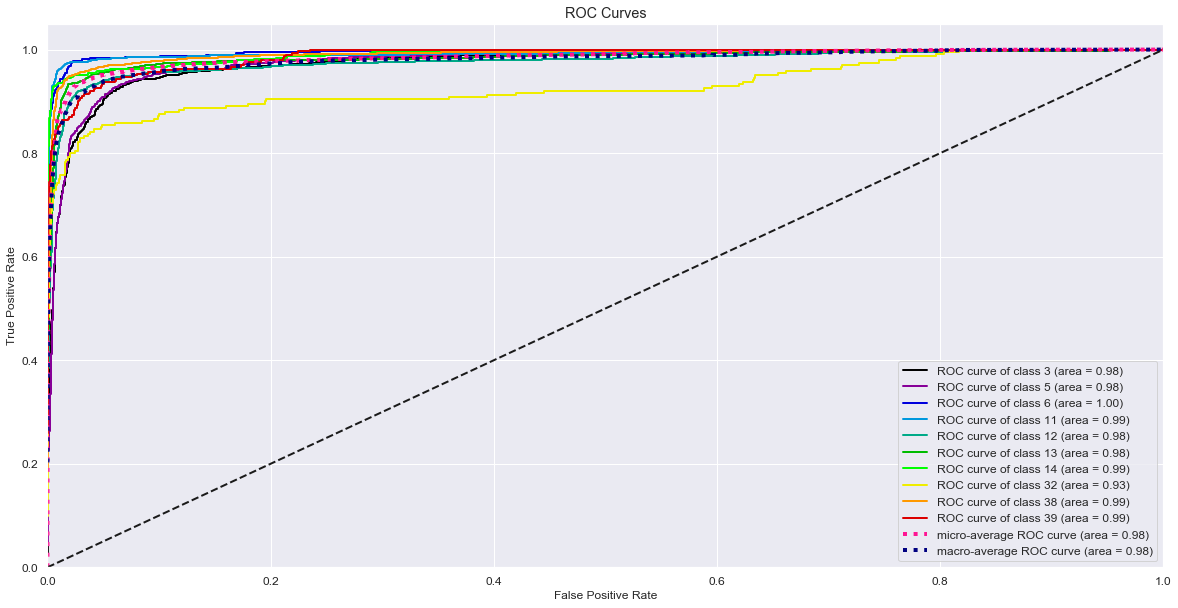

In [14]:
# Plot the ROC curves
skplt.metrics.plot_roc(labels, cv_predicted_proba, figsize=(20,10))

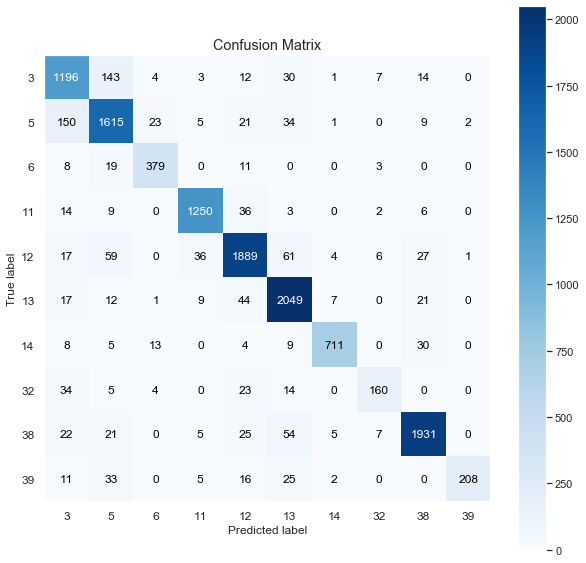

In [15]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(labels, cv_predicted, figsize=(10,10))

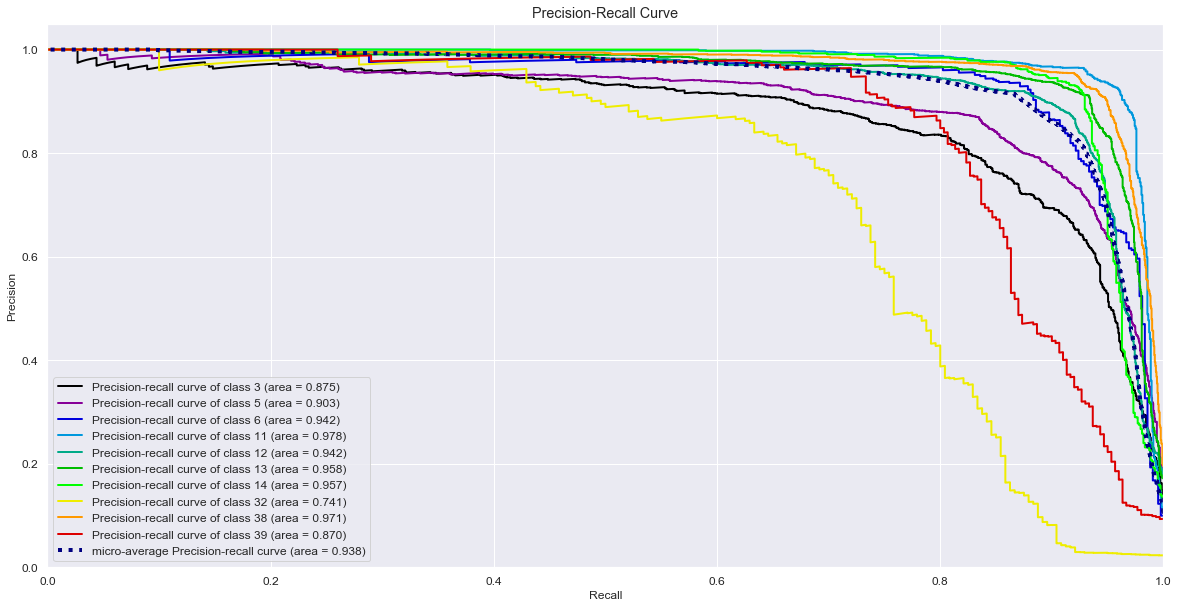

In [16]:
# Precision and recall
skplt.metrics.plot_precision_recall(labels, cv_predicted_proba, figsize=(20,10))

### With 70% training and 30% testing data split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    instances_and_features,
    labels,
    test_size=0.3, # 70% training, 30% testing
    stratify=labels # Stratified
)

In [18]:
logistic_regression.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=4, penalty='l2', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [19]:
predicted = logistic_regression.predict(X_test)
predicted_probas = logistic_regression.predict_proba(X_test)

In [20]:
# What's the accuracy score?
metrics.accuracy_score(y_test, predicted)

0.960242232754081

In [21]:
metrics.confusion_matrix(y_test, predicted)

array([[409,   6,   0,   0,   0,   3,   0,   0,   5,   0],
       [ 34, 510,   0,   1,   4,   1,   0,   0,   8,   0],
       [  6,   5, 110,   0,   2,   0,   0,   3,   0,   0],
       [  0,   0,   0, 391,   4,   0,   0,   0,   1,   0],
       [  3,   8,   0,   3, 604,   3,   0,   3,   6,   0],
       [  1,   3,   0,   1,   3, 635,   0,   1,   4,   0],
       [  0,   1,   0,   0,   0,   0, 230,   0,   3,   0],
       [  7,   2,   0,   0,   0,   1,   0,  62,   0,   0],
       [  1,   0,   0,   1,   0,   2,   3,   1, 613,   0],
       [  2,   1,   0,   2,   0,   2,   0,   0,   0,  83]])

In [22]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           3       0.88      0.97      0.92       423
           5       0.95      0.91      0.93       558
           6       1.00      0.87      0.93       126
          11       0.98      0.99      0.98       396
          12       0.98      0.96      0.97       630
          13       0.98      0.98      0.98       648
          14       0.99      0.98      0.99       234
          32       0.89      0.86      0.87        72
          38       0.96      0.99      0.97       621
          39       1.00      0.92      0.96        90

    accuracy                           0.96      3798
   macro avg       0.96      0.94      0.95      3798
weighted avg       0.96      0.96      0.96      3798



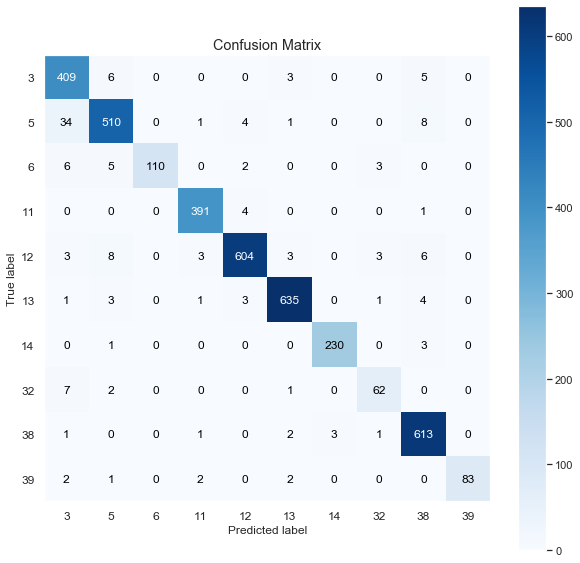

In [23]:
# Confusion matrix?
skplt.metrics.plot_confusion_matrix(y_test, predicted, figsize=(10,10))

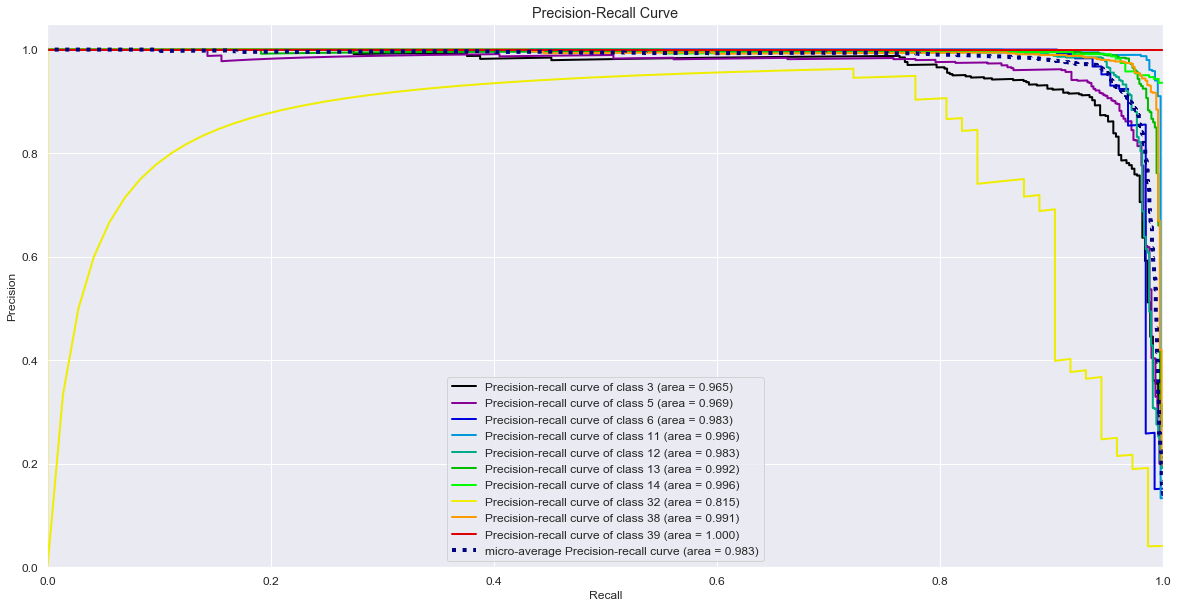

In [24]:
# Precision Recall Curves?
skplt.metrics.plot_precision_recall(y_test, predicted_probas, figsize=(20,10))

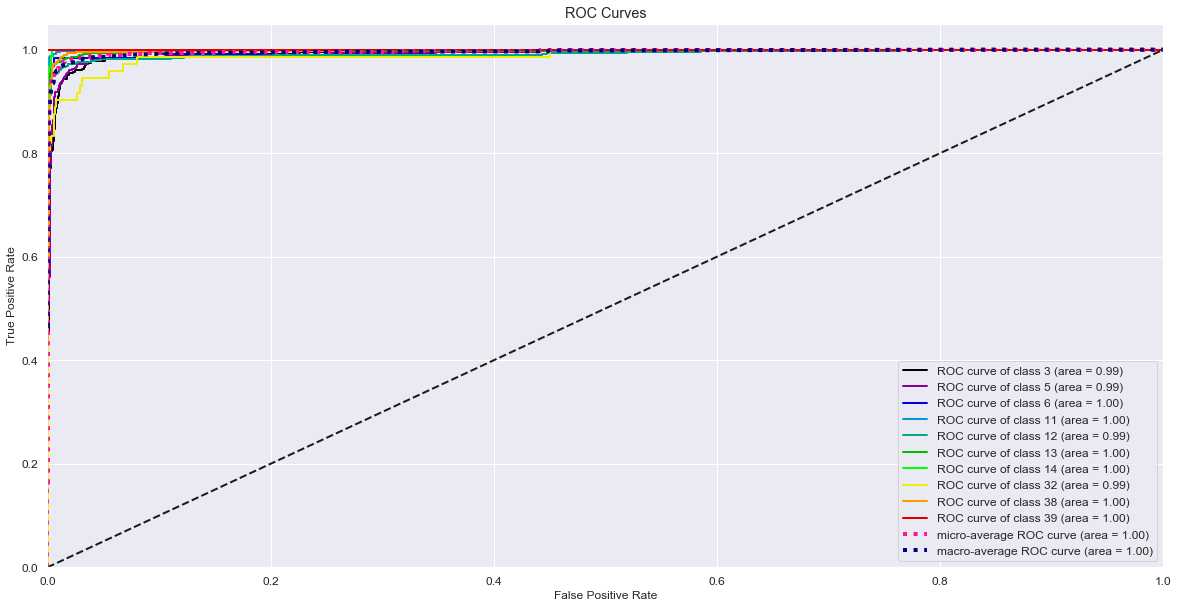

In [25]:
# ROC curves
skplt.metrics.plot_roc(y_test, predicted_probas, figsize=(20,10))

### With 30% training and 70% testing data split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    instances_and_features,
    labels,
    test_size=0.7, # 30% training, 70% testing
    stratify=labels # Stratified
)

In [27]:
logistic_regression.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=4, penalty='l2', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [28]:
predicted = logistic_regression.predict(X_test)
predicted_probas = logistic_regression.predict_proba(X_test)

In [29]:
# What's the accuracy score?
metrics.accuracy_score(y_test, predicted)

0.9326337169939065

In [30]:
metrics.confusion_matrix(y_test, predicted)

array([[ 833,   96,    2,    9,    8,    5,    3,   14,   17,    0],
       [  71, 1150,   13,    7,   29,    5,    0,    9,   18,    0],
       [   3,    1,  272,    0,    7,    0,    0,    7,    4,    0],
       [   1,    1,    0,  888,   21,    0,    2,    3,    8,    0],
       [  10,   18,    1,    7, 1397,    4,    3,    8,   22,    0],
       [   9,    2,    1,    2,   13, 1429,    6,    3,   47,    0],
       [   5,    1,    6,    1,    0,    1,  528,    0,    4,    0],
       [   4,    1,    1,    2,    7,    0,    0,  153,    0,    0],
       [   4,    1,    0,    0,    5,    1,    4,   11, 1423,    0],
       [   2,    4,    0,    3,    1,    5,    3,    0,    0,  192]])

In [31]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           3       0.88      0.84      0.86       987
           5       0.90      0.88      0.89      1302
           6       0.92      0.93      0.92       294
          11       0.97      0.96      0.96       924
          12       0.94      0.95      0.94      1470
          13       0.99      0.95      0.96      1512
          14       0.96      0.97      0.96       546
          32       0.74      0.91      0.81       168
          38       0.92      0.98      0.95      1449
          39       1.00      0.91      0.96       210

    accuracy                           0.93      8862
   macro avg       0.92      0.93      0.92      8862
weighted avg       0.93      0.93      0.93      8862



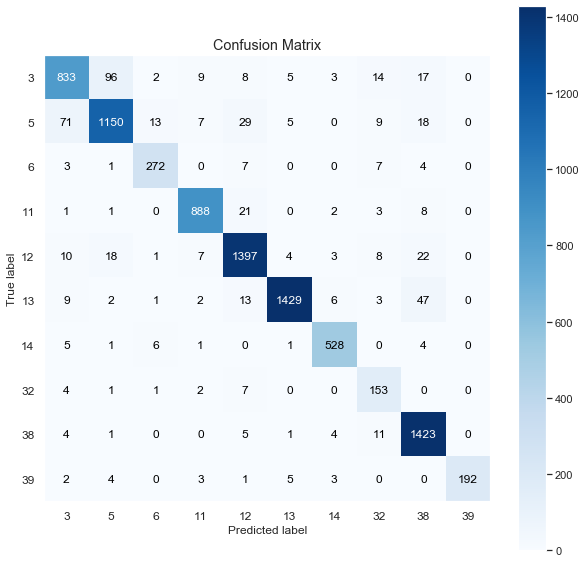

In [32]:
# Confusion matrix?
skplt.metrics.plot_confusion_matrix(y_test, predicted, figsize=(10,10))

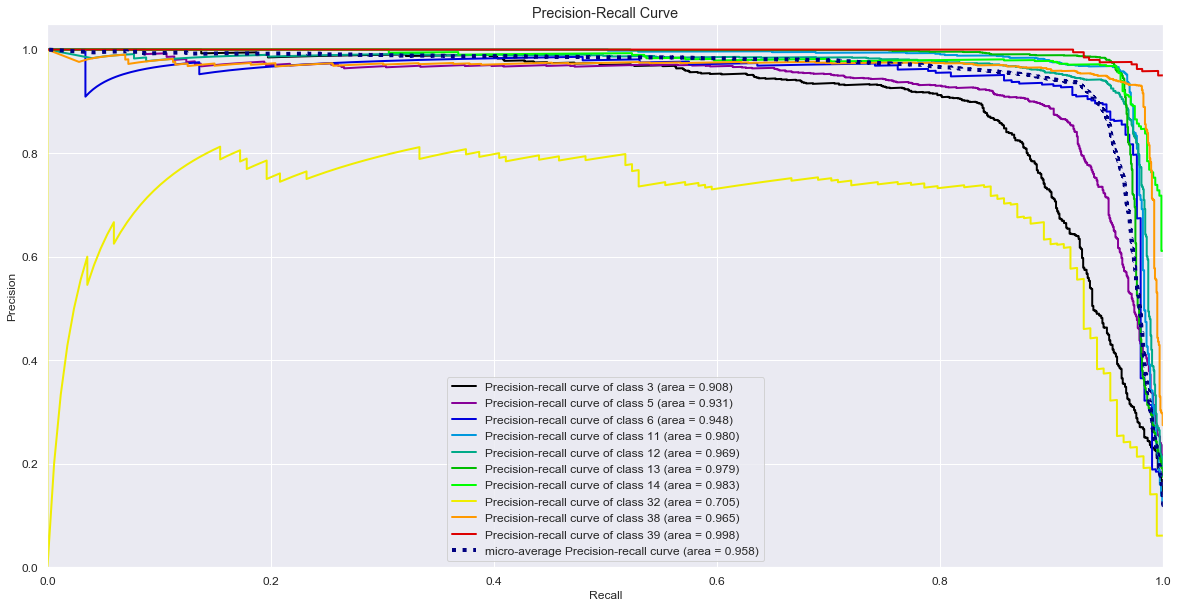

In [33]:
# Precision Recall Curves?
skplt.metrics.plot_precision_recall(y_test, predicted_probas, figsize=(20,10))

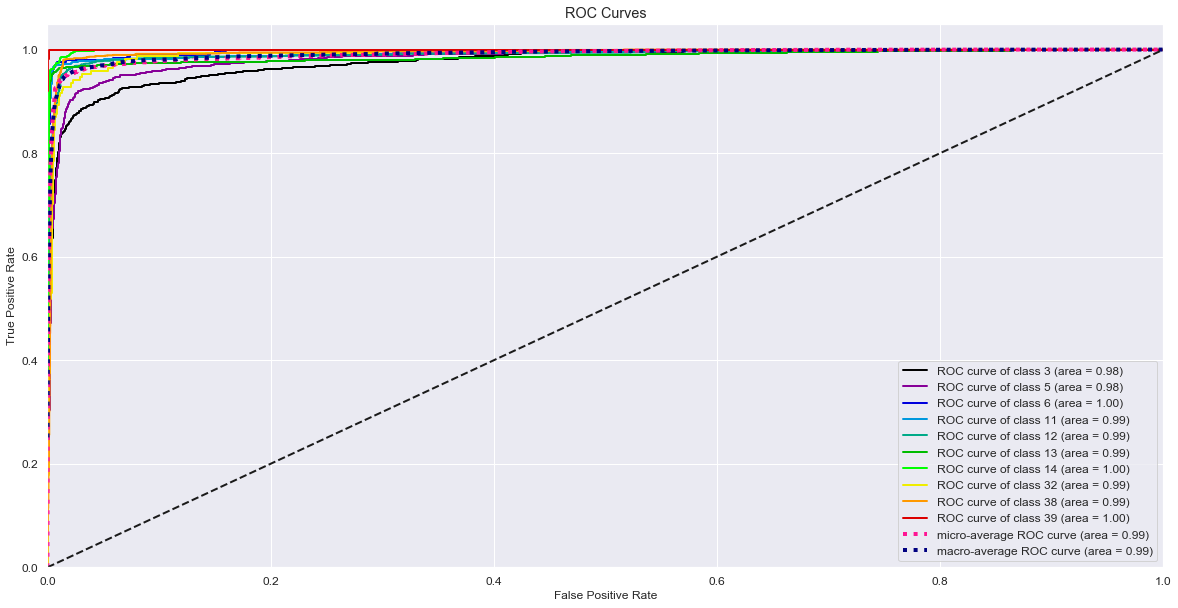

In [34]:
# ROC curves?
skplt.metrics.plot_roc(y_test, predicted_probas, figsize=(20,10))

# Multi-Layer Perceptron

## Finding the best one ***|||

We shall use the mean accuracy score to determin the best one. One with highest score wins.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    instances_and_features,
    labels,
    test_size=0.3, # 70% training, 30% testing
    stratify=labels # Stratified
)

In [36]:
mlp2 = MLPClassifier(
    hidden_layer_sizes=(10, ), # one hidden layer, 10 neurons
    activation='relu', # Zero if not class, something else if class
    random_state=0, # We like determinism
    solver='adam', # Solver for weight optimization
    max_iter=200, # Epochs
    learning_rate_init=0.001, # Step size
    # Sets the out activation function automatically based on number of classes
)
mlp2.out_activation_ = "softmax" # Multiclass classification

In [37]:
mlp2.fit(X_train, y_train)

/Users/timkofu/.local/share/virtualenvs/F21DLCW-Y6aQsTGC/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [38]:
mlp2.score(X_test, y_test)

0.9107424960505529

Let's try two layers of 10 neurons each

In [39]:
mlp3 = MLPClassifier(
    hidden_layer_sizes=(10, 10),
    activation='relu', # Zero if not class, something else if class
    random_state=0, # We like determinism
    solver='adam', # Solver for weight optimization
    max_iter=200, # Epochs
    learning_rate_init=0.001, # Step size
    # Sets the out activation function automatically based on number of classes
)
mlp3.out_activation_ = "softmax" # Multiclass classification

In [40]:
mlp3.fit(X_train, y_train)

/Users/timkofu/.local/share/virtualenvs/F21DLCW-Y6aQsTGC/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [41]:
mlp3.score(X_test, y_test)

0.48894154818325436

Much worse. I'll try 1000 epochs with 1 hidden layer of 128 neurons

In [42]:
mlp4 = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation='relu', # Zero if not class, something else if class
    random_state=0, # We like determinism
    solver='adam', # Solver for weight optimization
    max_iter=1000, # Epochs
    learning_rate_init=0.001, # Step size
    # Sets the out activation function automatically based on number of classes
)
mlp4.out_activation_ = "softmax" # Multiclass classification

In [43]:
mlp4.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [44]:
mlp4.score(X_test, y_test)

0.976303317535545

Is it the layers or the epochs? Adding another 128 neuron layer to test.

In [45]:
mlp5 = MLPClassifier(
    hidden_layer_sizes=(128, 128),
    activation='relu', # Zero if not class, something else if class
    random_state=0, # We like determinism
    solver='adam', # Solver for weight optimization
    max_iter=1000, # Epochs
    learning_rate_init=0.001, # Step size
    # Sets the out activation function automatically based on number of classes
)
mlp5.out_activation_ = "softmax" # Multiclass classification

In [46]:
mlp5.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128, 128), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [47]:
mlp5.score(X_test, y_test)

0.9831490258030542

One more layer

In [48]:
mlp6 = MLPClassifier(
    hidden_layer_sizes=(128, 128, 128),
    activation='relu', # Zero if not class, something else if class
    random_state=0, # We like determinism
    solver='adam', # Solver for weight optimization
    max_iter=1000, # Epochs
    learning_rate_init=0.001, # Step size
    # Sets the out activation function automatically based on number of classes
)
mlp6.out_activation_ = "softmax" # Multiclass classification

In [49]:
mlp6.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128, 128, 128), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [50]:
mlp6.score(X_test, y_test)

0.9802527646129542

One more layer half the size of the others would help?

In [51]:
mlp7 = MLPClassifier(
    hidden_layer_sizes=(128, 128, 128, 64),
    activation='relu', # Zero if not class, something else if class
    random_state=0, # We like determinism
    solver='adam', # Solver for weight optimization
    max_iter=1000, # Epochs
    learning_rate_init=0.001, # Step size
    # Sets the out activation function automatically based on number of classes
)
mlp7.out_activation_ = "softmax" # Multiclass classification

In [52]:
mlp7.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128, 128, 128, 64), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [53]:
mlp7.score(X_test, y_test)

0.968667719852554

Two hidden layers with 128 neurons each with ReLu activation function and Softmax in the output performed best.

## ***

In [54]:
goldmaster_nn = mlp5

## *** |||

## With 10-fold cross validation

In [55]:
# The 10 fold cross validation
cv_results = cross_validate(
    goldmaster_nn,
    instances_and_features, labels,
    cv=10
)

In [56]:
cv_results['test_score']

array([0.87835703, 0.91627172, 0.95734597, 0.91943128, 0.93601896,
       0.9399684 , 0.93522907, 0.89968404, 0.94865719, 0.92890995])

In [57]:
print(f"The best accuracy score is: {cv_results['test_score'].max()}")

The best accuracy score is: 0.957345971563981


Did not perform as well as the 70-30 split.

In [58]:
# Predicted
cv_predicted = cross_val_predict(
    goldmaster_nn,
    instances_and_features, labels,
    cv=10,
)

# And predicted probabilities
cv_predicted_proba = cross_val_predict(
    goldmaster_nn,
    instances_and_features, labels,
    cv=10,
    method='predict_proba'
)

In [59]:
metrics.confusion_matrix(labels, cv_predicted)

array([[1134,  222,    4,    6,   11,    2,    1,   12,   18,    0],
       [ 124, 1690,    4,    2,   22,    4,    0,    2,   11,    1],
       [   5,    0,  406,    0,    1,    0,    0,    8,    0,    0],
       [  10,   14,    0, 1261,   30,    0,    0,    2,    3,    0],
       [  12,   46,    2,   15, 1991,    8,    0,    3,   22,    1],
       [  11,    2,    1,    2,   46, 2070,    3,    0,   24,    1],
       [   2,    1,    0,    0,    1,    3,  768,    0,    4,    1],
       [  16,    7,   25,    0,    4,    1,    0,  186,    1,    0],
       [  32,   23,    0,    1,   31,   12,    2,    3, 1966,    0],
       [   2,   40,    0,    0,    0,    7,    0,    0,    0,  251]])

In [60]:
print(metrics.classification_report(labels, cv_predicted))

              precision    recall  f1-score   support

           3       0.84      0.80      0.82      1410
           5       0.83      0.91      0.87      1860
           6       0.92      0.97      0.94       420
          11       0.98      0.96      0.97      1320
          12       0.93      0.95      0.94      2100
          13       0.98      0.96      0.97      2160
          14       0.99      0.98      0.99       780
          32       0.86      0.78      0.82       240
          38       0.96      0.95      0.95      2070
          39       0.98      0.84      0.90       300

    accuracy                           0.93     12660
   macro avg       0.93      0.91      0.92     12660
weighted avg       0.93      0.93      0.93     12660



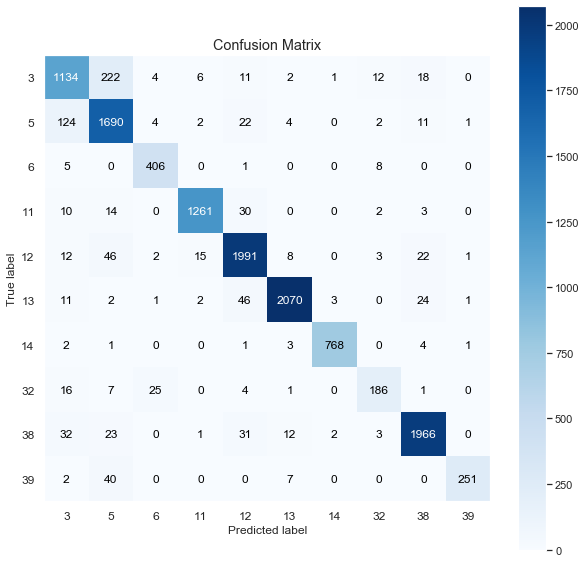

In [61]:
# Confusion matrix?
skplt.metrics.plot_confusion_matrix(labels, cv_predicted, figsize=(10,10))

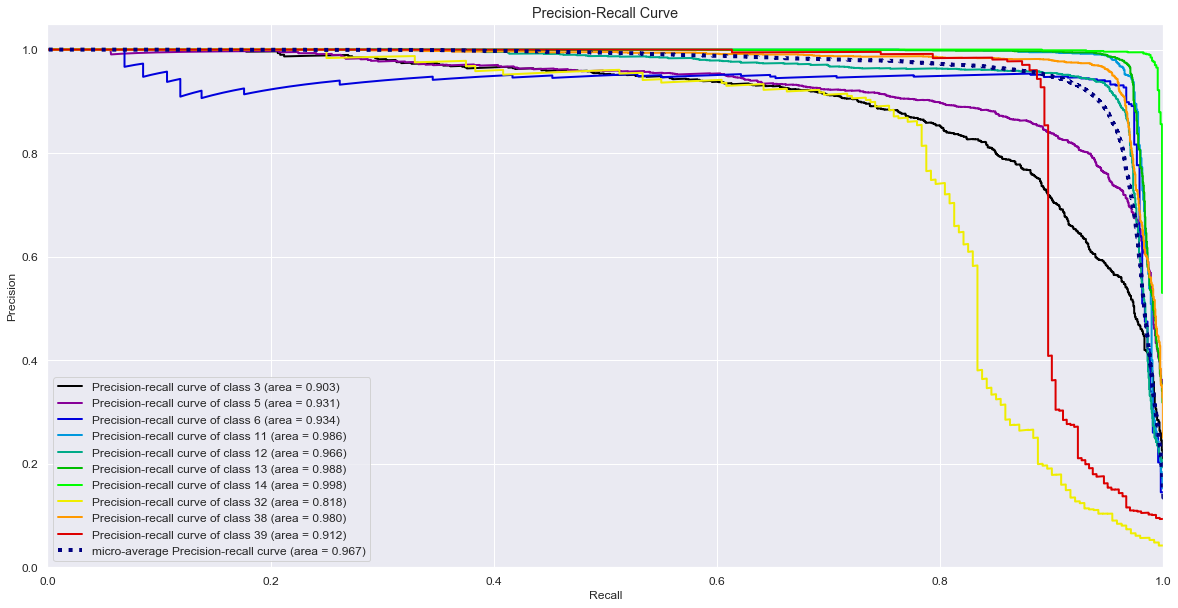

In [62]:
# Precision Recall Curves?
skplt.metrics.plot_precision_recall(labels, cv_predicted_proba, figsize=(20,10))

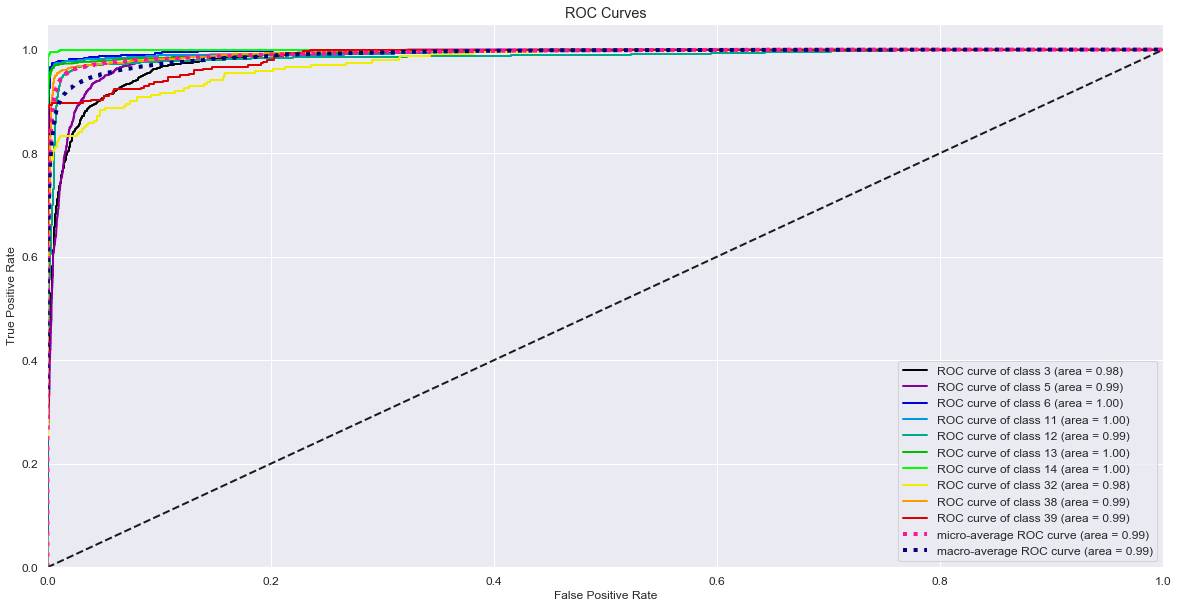

In [63]:
# ROC curves?
skplt.metrics.plot_roc(labels, cv_predicted_proba, figsize=(20,10))

### With 70% training and 30% testing data stratified split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    instances_and_features,
    labels,
    test_size=0.3, # 70% training, 30% testing
    stratify=labels # Stratified
)

In [65]:
goldmaster_nn.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128, 128), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [66]:
goldmaster_nn.score(X_test, y_test)

0.9689310163243813

In [68]:
predicted = goldmaster_nn.predict(X_test)
predicted_probas = goldmaster_nn.predict_proba(X_test)

In [69]:
metrics.confusion_matrix(y_test, predicted)

array([[414,   6,   1,   0,   1,   1,   0,   0,   0,   0],
       [ 27, 529,   0,   0,   0,   1,   0,   0,   1,   0],
       [  1,   0, 122,   0,   1,   0,   0,   2,   0,   0],
       [ 16,   5,   0, 372,   3,   0,   0,   0,   0,   0],
       [  6,   8,   0,   0, 610,   0,   0,   1,   5,   0],
       [  3,   0,   0,   0,   2, 642,   0,   0,   1,   0],
       [  1,   1,   0,   0,   0,   0, 230,   0,   2,   0],
       [  9,   0,   1,   0,   1,   0,   0,  61,   0,   0],
       [  4,   1,   0,   0,   1,   4,   0,   0, 611,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   0,  89]])

In [70]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           3       0.86      0.98      0.92       423
           5       0.96      0.95      0.95       558
           6       0.98      0.97      0.98       126
          11       1.00      0.94      0.97       396
          12       0.99      0.97      0.98       630
          13       0.99      0.99      0.99       648
          14       1.00      0.98      0.99       234
          32       0.95      0.85      0.90        72
          38       0.99      0.98      0.98       621
          39       1.00      0.99      0.99        90

    accuracy                           0.97      3798
   macro avg       0.97      0.96      0.96      3798
weighted avg       0.97      0.97      0.97      3798



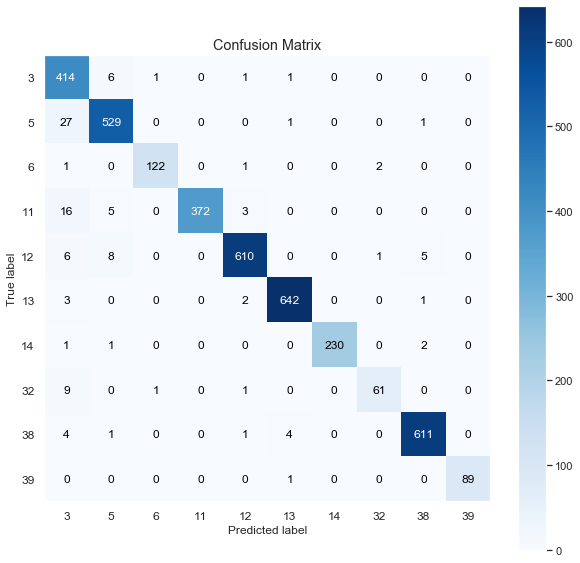

In [71]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, predicted, figsize=(10,10))

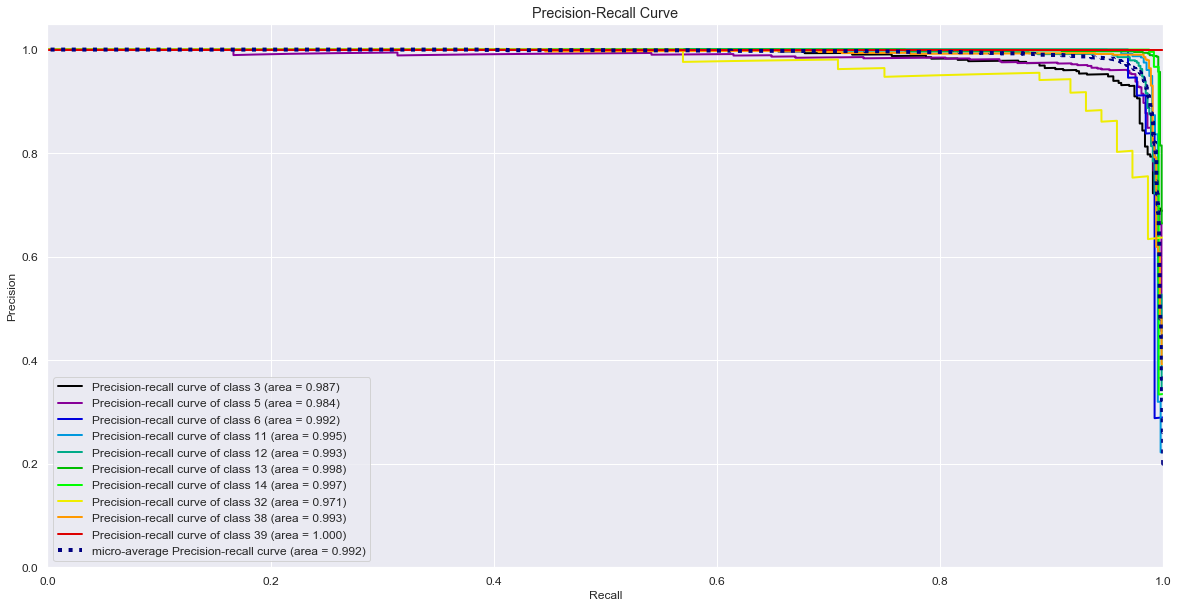

In [72]:
# Precision Recall Curves
skplt.metrics.plot_precision_recall(y_test, predicted_probas, figsize=(20,10))

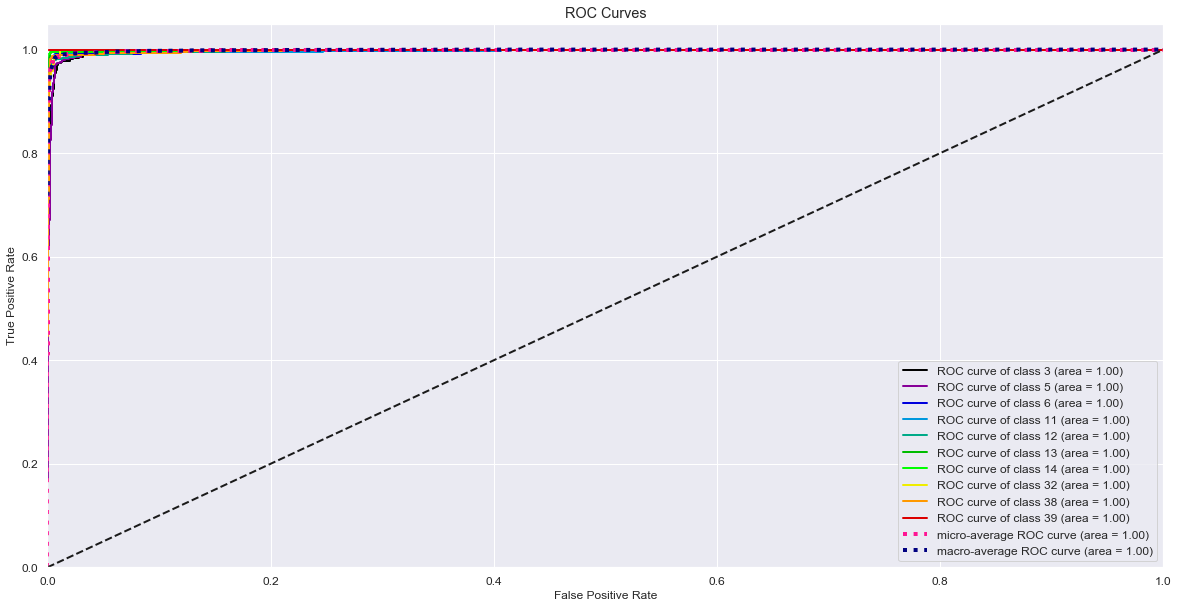

In [73]:
# ROC curves
skplt.metrics.plot_roc(y_test, predicted_probas, figsize=(20,10))

### With 30% training and 70% testing data stratified split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    instances_and_features,
    labels,
    test_size=0.7, # 30% training, 70% testing
    stratify=labels # Stratified
)

In [75]:
goldmaster_nn.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128, 128), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [76]:
goldmaster_nn.score(X_test, y_test)

0.9466260437824419

In [77]:
predicted = goldmaster_nn.predict(X_test)
predicted_probas = goldmaster_nn.predict_proba(X_test)

In [78]:
metrics.confusion_matrix(y_test, predicted)

array([[ 912,   31,    0,   13,   12,    2,    1,    3,   13,    0],
       [ 102, 1125,    0,   40,   19,    2,    0,    4,    8,    2],
       [   0,    0,  284,    0,    2,    0,    0,    8,    0,    0],
       [   1,    2,    0,  909,    6,    0,    0,    1,    5,    0],
       [   2,   21,    1,   32, 1391,    4,    0,   10,    9,    0],
       [   5,    1,    0,    5,   15, 1451,   10,    2,   22,    1],
       [   1,    0,    0,    0,    3,    0,  538,    0,    3,    1],
       [  11,    0,    4,    4,    4,    0,    0,  144,    1,    0],
       [   6,    2,    0,    5,    2,    1,    1,    2, 1430,    0],
       [   0,    2,    0,    0,    0,    2,    1,    0,    0,  205]])

In [79]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           3       0.88      0.92      0.90       987
           5       0.95      0.86      0.91      1302
           6       0.98      0.97      0.97       294
          11       0.90      0.98      0.94       924
          12       0.96      0.95      0.95      1470
          13       0.99      0.96      0.98      1512
          14       0.98      0.99      0.98       546
          32       0.83      0.86      0.84       168
          38       0.96      0.99      0.97      1449
          39       0.98      0.98      0.98       210

    accuracy                           0.95      8862
   macro avg       0.94      0.94      0.94      8862
weighted avg       0.95      0.95      0.95      8862



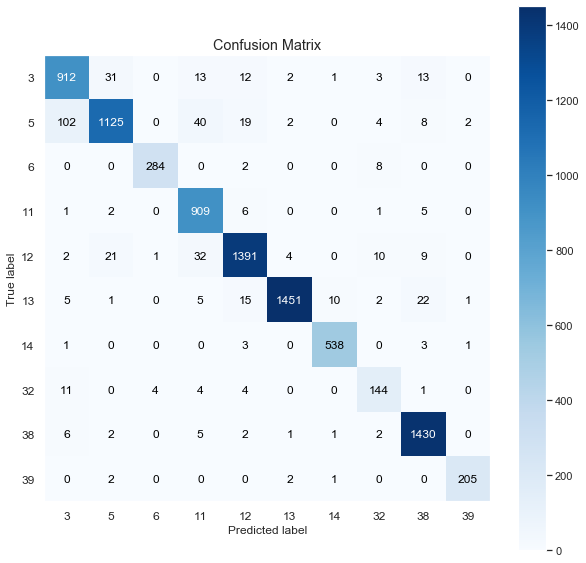

In [80]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, predicted, figsize=(10,10))

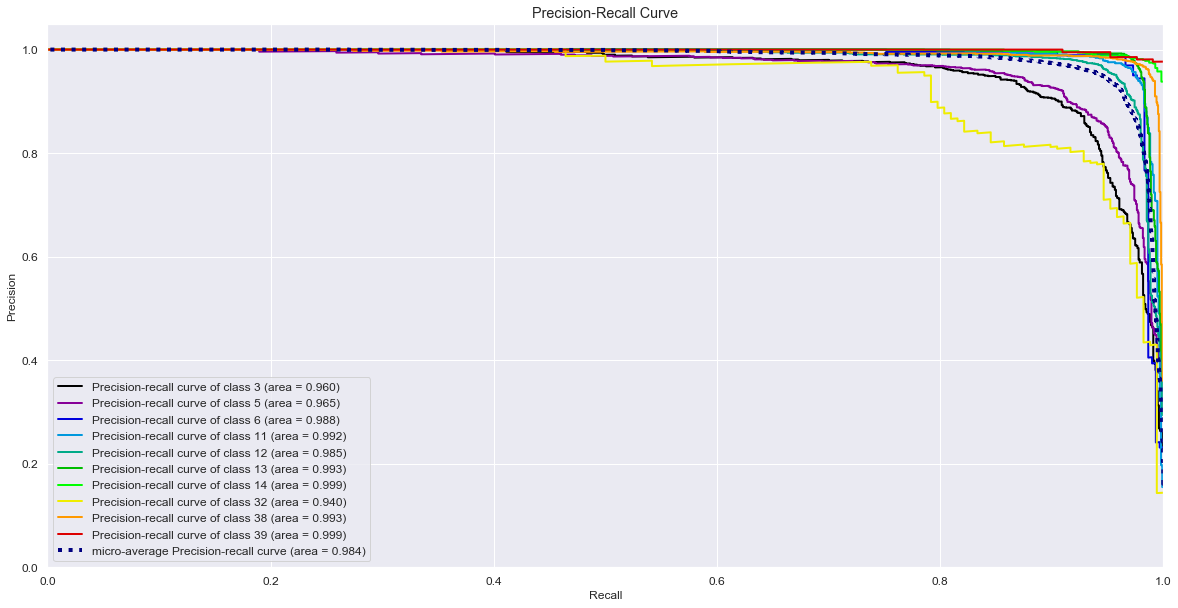

In [81]:
# Precision Recall Curves
skplt.metrics.plot_precision_recall(y_test, predicted_probas, figsize=(20,10))

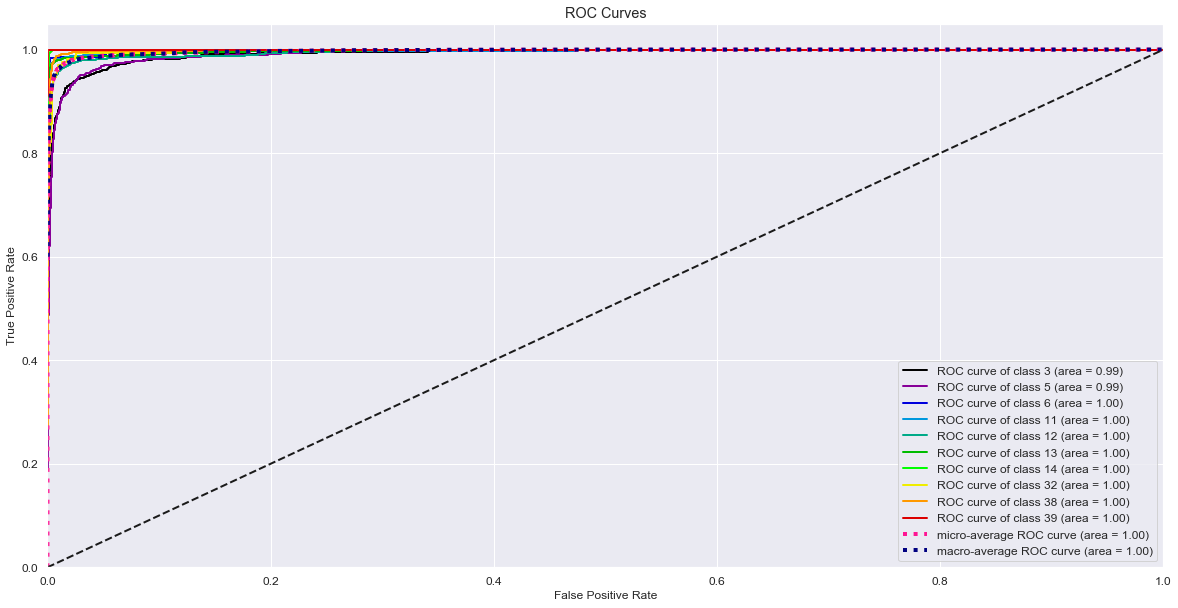

In [82]:
# ROC curves
skplt.metrics.plot_roc(y_test, predicted_probas, figsize=(20,10))

### Predicting one instance and visualizing it

Let's pick one instance out of the test set and predict the class probabilities

In [91]:
class_probabilities = goldmaster_nn.predict_proba(X_test[26:27,:])

In [92]:
class_probabilities

array([[2.36120271e-02, 3.80473626e-01, 5.54848050e-06, 5.81262840e-01,
        7.49145108e-03, 2.21217800e-03, 1.64975226e-05, 1.19323534e-04,
        4.58448297e-03, 2.22025349e-04]])

This predicts it's the 5th class, which accourding to oyr map shoult be "right of way general". Let's visualize it to make sure.

In [116]:
image = dataset.iloc[200]
image

0        28
1        27
2        27
3        28
4        29
         ..
2300     27
2301     28
2302     27
2303     25
label     3
Name: 200, Length: 2305, dtype: int64

In [117]:
goldmaster_nn.predict_proba(image[:-1].values.reshape(1, -1))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

It says it's the first one in the order of labels, which is label 3, and we can see it indeed is label three.

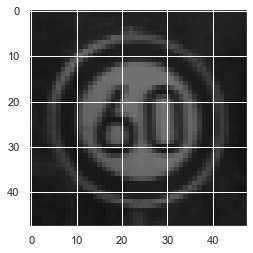

In [118]:
plt.imshow(
    image[:-1].values.reshape((48,48)),
    cmap='gray',  # Tell matplot lib the image is grayscale
    vmin=0, vmax=255  # Tell matplotlib the range of pixels
)

One more:

In [119]:
image = dataset.iloc[7777]
image

0        255
1        255
2        255
3        255
4        255
        ... 
2300     110
2301     119
2302     166
2303     219
label     13
Name: 7777, Length: 2305, dtype: int64

In [120]:
goldmaster_nn.predict_proba(image[:-1].values.reshape(1, -1))

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

This time it predicts it's the 6th label, which is 13 "give_way". Let's visualize it

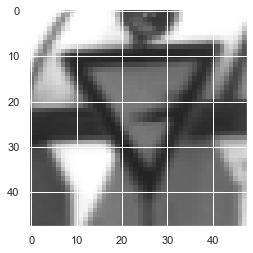

In [121]:
plt.imshow(
    image[:-1].values.reshape((48,48)),
    cmap='gray',  # Tell matplot lib the image is grayscale
    vmin=0, vmax=255  # Tell matplotlib the range of pixels
)

Both predictions are correct.

## How does Tensorflow compare to scikit-learn?

First we make a keras model and make sure it's performing the same

In [123]:
keras_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [124]:
keras_model.compile(optimizer= 'adam' , loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [125]:
# Convert the labels from 0-9
def convert_to_zero_to_nine(in_num):
    if in_num == 3:
        return 0
    elif in_num == 5:
        return 1
    elif in_num == 6:
        return 2
    elif in_num == 11:
        return 3
    elif in_num == 12:
        return 4
    elif in_num == 13:
        return 5
    elif in_num == 14:
        return 6
    elif in_num == 32:
        return 7
    elif in_num == 38:
        return 8
    elif in_num == 39:
        return 9
c2n = np.vectorize(convert_to_zero_to_nine)

In [126]:
converted_labels = c2n(labels)

In [127]:
# Do the proper train-test split
X_train, X_test, y_train, y_test = train_test_split(
    instances_and_features,
    converted_labels,
    test_size=0.3, # 70% training, 30% testing
    stratify=labels # Stratified
)

In [128]:
# Train the model
keras_model.fit(X_train, y_train, epochs=100) # Only needed 83 epochs to hit convergence

Train on 8862 samples
Epoch 1/100
8862/8862 [==============================] - 1s 130us/sample - loss: 1.1574 - accuracy: 0.6520
Epoch 2/100
8862/8862 [==============================] - 1s 76us/sample - loss: 0.5416 - accuracy: 0.8383
Epoch 3/100
8862/8862 [==============================] - 1s 74us/sample - loss: 0.3715 - accuracy: 0.8869
Epoch 4/100
8862/8862 [==============================] - 1s 74us/sample - loss: 0.3230 - accuracy: 0.9043
Epoch 5/100
8862/8862 [==============================] - 1s 75us/sample - loss: 0.2855 - accuracy: 0.9115
Epoch 6/100
8862/8862 [==============================] - 1s 72us/sample - loss: 0.2231 - accuracy: 0.9298
Epoch 7/100
8862/8862 [==============================] - 1s 74us/sample - loss: 0.2215 - accuracy: 0.9359
Epoch 8/100
8862/8862 [==============================] - 1s 74us/sample - loss: 0.2224 - accuracy: 0.9324
Epoch 9/100
8862/8862 [==============================] - 1s 74us/sample - loss: 0.1679 - accuracy: 0.9475
Epoch 10/100
8862/8862 

In [129]:
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  295040    
_________________________________________________________________
dense_9 (Dense)              multiple                  16512     
_________________________________________________________________
dense_10 (Dense)             multiple                  1290      
Total params: 312,842
Trainable params: 312,842
Non-trainable params: 0
_________________________________________________________________


In [130]:
keras_model.evaluate(X_test, y_test)

3798/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.17265379419789076, 0.9694576]

98% accuracy.

In [136]:
predicted = keras_model.predict(X_test)
predicted_probas = keras_model.predict_proba(X_test)

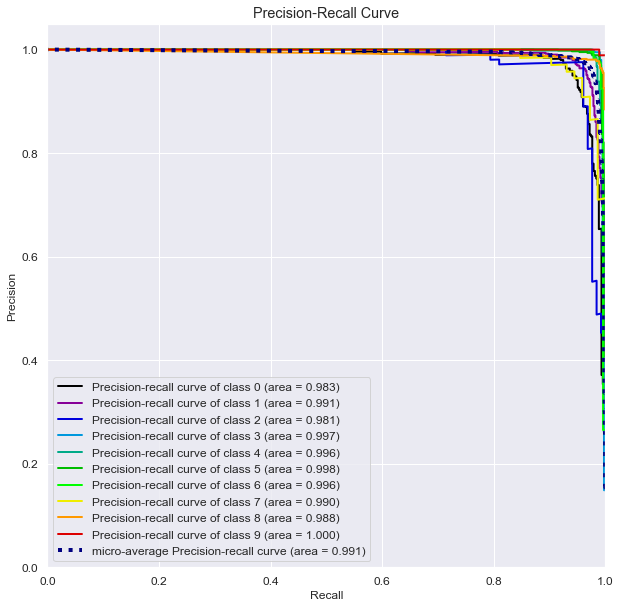

In [132]:
# Confusion matrix
skplt.metrics.plot_precision_recall(y_test, predicted_probas, figsize=(10,10))

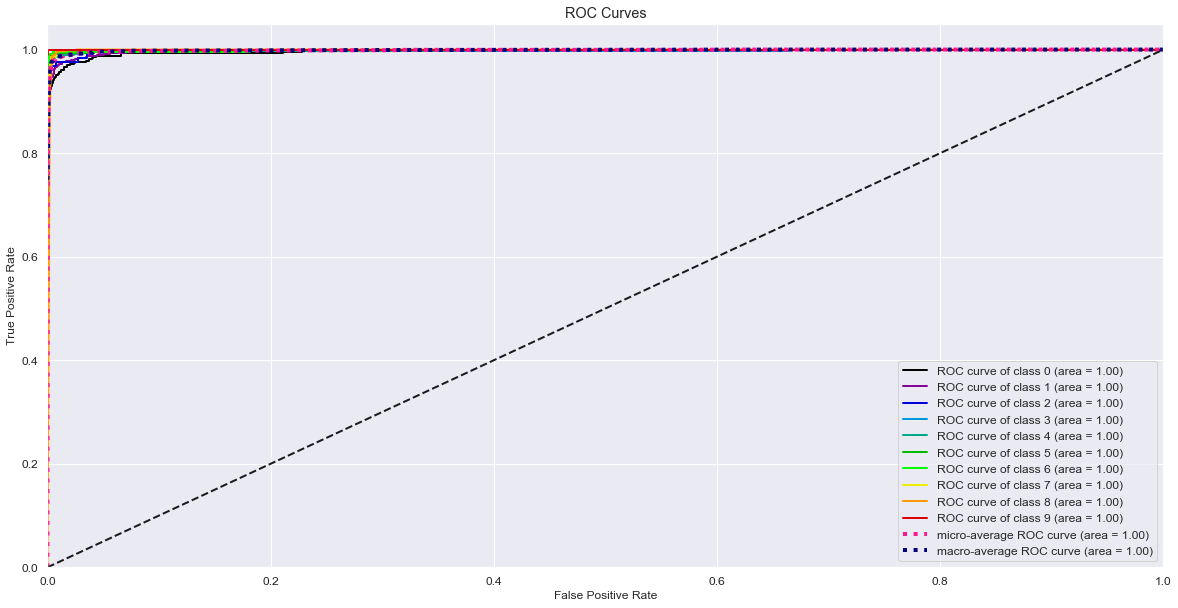

In [133]:
# ROC curves
skplt.metrics.plot_roc(y_test, predicted_probas, figsize=(20,10))

More or less the same. They are both using the same math, so no surprise there.